In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.image as mpimg


import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image


In [2]:
dev = None
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

In [3]:
device

device(type='cuda', index=0)

In [4]:
# Parameters
batch_size = 64
image_size = 64

eps=1e-7
# z_size = 50
# ngf=32
# nc = 1

# Root directory for dataset
dataroot = "./pokemon"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Dataset

In [5]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = [img for img in os.listdir(main_dir) if img.lower().endswith(".png") and "-back-" not in img and os.stat(os.path.join(main_dir, img)).st_size > 900]
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image


In [6]:
transform = transforms.Compose(
    [transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
) #transforms.Resize(image_size),
# Try a few different normalizations
# and make sure generators output to the same range, then generator doesn't have to learn range

In [7]:
img_folder_path = "./pokemon"

In [8]:
my_dataset = CustomDataSet(img_folder_path, transform=transform)
trainloader = torch.utils.data.DataLoader(my_dataset , batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=True)


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


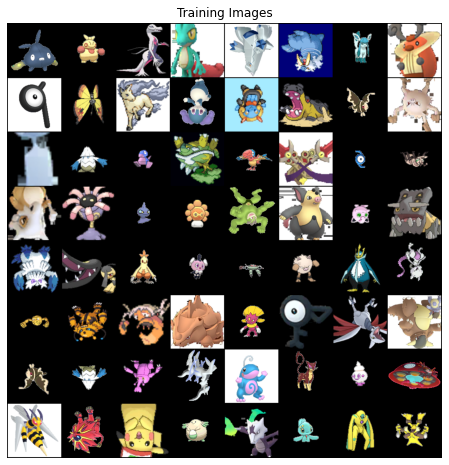

In [9]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [11]:
len(trainloader)

231

# Networks

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class DiscriminatorConvNet(nn.Module):    
    def __init__(self):
        super(DiscriminatorConvNet, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(start_dim=1)
        )
    

    def forward(self, x):
        return self.main(x)

D = DiscriminatorConvNet().to(device)
# D.apply(weights_init)
D

DiscriminatorConvNet(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(204

In [14]:
# test input
inp = torch.randn(2,nc,image_size,image_size).to(device)
d_out = D(inp)
print(d_out)
d_image_out = D(real_batch.to(device))
print(d_image_out.shape)

tensor([[0.6410],
        [0.5079]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
torch.Size([64, 1])


# Define the generator network

In [15]:
class GeneratorConvNet(nn.Module):
    def __init__(self):
        super(GeneratorConvNet, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, x):
        return self.main(x)

G = GeneratorConvNet().to(device)
# G.apply(weights_init)
G

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [16]:
# test input
inp = torch.randn(2, nz, 1, 1).to(device)
g_out = G(inp)
print(g_out.shape)

torch.Size([2, 3, 128, 128])


In [17]:
# Try running G out through D
d_of_g_out = D(g_out)
print(d_of_g_out)

tensor([[0.4802],
        [0.5289]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


In [18]:
noise_generator = lambda x: torch.FloatTensor(x, nz, 1, 1).uniform_(0, 1) # pg(z) torch.randn(x, z_size)
noise_generator(2).shape

torch.Size([2, 100, 1, 1])

# Train algorithm

In [19]:
# Define the train parameters
# num_epochs = 12
# batch_size = 128
k_steps = 1
num_val_batches = 10


In [20]:
dataloader = trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=True)

#pdata(x)
# train_real_sampler = iter(trainloader)
# val_real_sampler = train_real_sampler

In [21]:
# pg(z)
noise_generator = lambda x: torch.FloatTensor(x, nz, 1, 1).to(device)
noise_generator(2).shape

torch.Size([2, 100, 1, 1])

In [22]:
optimizerD = optim.Adam(D.parameters(), lr=lr/10, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
D.to(device)
G.to(device)

# G.apply(weights_init)
# D.apply(weights_init)

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [24]:
criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [25]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
broke = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if epoch > 15 and 0.48 <= D_x <= 0.52 and 0.48 <= D_G_z2 <= 0.52: 
#             broke = True
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#             break

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if broke: break

Starting Training Loop...


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0/30][0/231]	Loss_D: 1.4628	Loss_G: 2.1647	D(x): 0.4678	D(G(z)): 0.4884 / 0.1180
[0/30][50/231]	Loss_D: 0.6953	Loss_G: 9.1912	D(x): 0.8898	D(G(z)): 0.4178 / 0.0001
[0/30][100/231]	Loss_D: 0.5871	Loss_G: 9.4187	D(x): 0.8864	D(G(z)): 0.3278 / 0.0001
[0/30][150/231]	Loss_D: 0.7892	Loss_G: 7.5552	D(x): 0.7916	D(G(z)): 0.3031 / 0.0014
[0/30][200/231]	Loss_D: 1.1865	Loss_G: 1.2932	D(x): 0.4801	D(G(z)): 0.2110 / 0.3209


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[1/30][0/231]	Loss_D: 0.9719	Loss_G: 1.7551	D(x): 0.6651	D(G(z)): 0.3835 / 0.1954
[1/30][50/231]	Loss_D: 1.5288	Loss_G: 0.5727	D(x): 0.2950	D(G(z)): 0.1355 / 0.5853
[1/30][100/231]	Loss_D: 1.1860	Loss_G: 1.7631	D(x): 0.6674	D(G(z)): 0.5131 / 0.1875
[1/30][150/231]	Loss_D: 1.4816	Loss_G: 1.6505	D(x): 0.7229	D(G(z)): 0.6520 / 0.2100
[1/30][200/231]	Loss_D: 1.3701	Loss_G: 0.9950	D(x): 0.5082	D(G(z)): 0.4819 / 0.3782


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[2/30][0/231]	Loss_D: 1.1977	Loss_G: 1.0662	D(x): 0.4985	D(G(z)): 0.3726 / 0.3528
[2/30][50/231]	Loss_D: 1.1501	Loss_G: 1.1152	D(x): 0.5616	D(G(z)): 0.4108 / 0.3380
[2/30][100/231]	Loss_D: 1.1880	Loss_G: 0.9743	D(x): 0.5813	D(G(z)): 0.4557 / 0.3875
[2/30][150/231]	Loss_D: 1.3182	Loss_G: 1.0208	D(x): 0.5451	D(G(z)): 0.4872 / 0.3731
[2/30][200/231]	Loss_D: 1.2360	Loss_G: 0.7176	D(x): 0.4435	D(G(z)): 0.3156 / 0.5015


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[3/30][0/231]	Loss_D: 1.3340	Loss_G: 1.1321	D(x): 0.4665	D(G(z)): 0.3898 / 0.3436
[3/30][50/231]	Loss_D: 1.1618	Loss_G: 1.5378	D(x): 0.6553	D(G(z)): 0.5000 / 0.2300
[3/30][100/231]	Loss_D: 1.4468	Loss_G: 2.0479	D(x): 0.7355	D(G(z)): 0.6566 / 0.1461
[3/30][150/231]	Loss_D: 1.2632	Loss_G: 1.2767	D(x): 0.5192	D(G(z)): 0.4276 / 0.2920
[3/30][200/231]	Loss_D: 1.1559	Loss_G: 1.1754	D(x): 0.5894	D(G(z)): 0.4416 / 0.3340


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[4/30][0/231]	Loss_D: 1.5377	Loss_G: 0.7526	D(x): 0.3765	D(G(z)): 0.3869 / 0.5018
[4/30][50/231]	Loss_D: 1.1679	Loss_G: 1.4984	D(x): 0.6920	D(G(z)): 0.5300 / 0.2454
[4/30][100/231]	Loss_D: 1.3955	Loss_G: 1.2912	D(x): 0.5774	D(G(z)): 0.5451 / 0.2842
[4/30][150/231]	Loss_D: 1.4062	Loss_G: 0.7370	D(x): 0.4619	D(G(z)): 0.4364 / 0.4898
[4/30][200/231]	Loss_D: 1.4404	Loss_G: 1.8371	D(x): 0.7134	D(G(z)): 0.6351 / 0.1708


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[5/30][0/231]	Loss_D: 1.3011	Loss_G: 0.7114	D(x): 0.4235	D(G(z)): 0.3263 / 0.4983
[5/30][50/231]	Loss_D: 1.1779	Loss_G: 1.5801	D(x): 0.6387	D(G(z)): 0.4911 / 0.2224
[5/30][100/231]	Loss_D: 1.2299	Loss_G: 1.1783	D(x): 0.4793	D(G(z)): 0.3616 / 0.3256
[5/30][150/231]	Loss_D: 1.2335	Loss_G: 0.7721	D(x): 0.4207	D(G(z)): 0.2768 / 0.4773
[5/30][200/231]	Loss_D: 1.2172	Loss_G: 1.4787	D(x): 0.5698	D(G(z)): 0.4536 / 0.2437


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[6/30][0/231]	Loss_D: 1.3713	Loss_G: 1.2257	D(x): 0.6295	D(G(z)): 0.5595 / 0.3196
[6/30][50/231]	Loss_D: 1.3147	Loss_G: 0.8607	D(x): 0.5875	D(G(z)): 0.5198 / 0.4377
[6/30][100/231]	Loss_D: 1.1627	Loss_G: 1.3544	D(x): 0.6170	D(G(z)): 0.4734 / 0.2661
[6/30][150/231]	Loss_D: 1.4146	Loss_G: 0.7954	D(x): 0.3574	D(G(z)): 0.2515 / 0.4639
[6/30][200/231]	Loss_D: 1.3382	Loss_G: 1.6995	D(x): 0.7068	D(G(z)): 0.6040 / 0.1953


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[7/30][0/231]	Loss_D: 0.9759	Loss_G: 2.1690	D(x): 0.6219	D(G(z)): 0.3813 / 0.1227
[7/30][50/231]	Loss_D: 1.3021	Loss_G: 2.0864	D(x): 0.7468	D(G(z)): 0.6128 / 0.1393
[7/30][100/231]	Loss_D: 0.9944	Loss_G: 1.3678	D(x): 0.6599	D(G(z)): 0.4157 / 0.2678
[7/30][150/231]	Loss_D: 1.0881	Loss_G: 1.7343	D(x): 0.6087	D(G(z)): 0.4250 / 0.1926
[7/30][200/231]	Loss_D: 1.6685	Loss_G: 1.7865	D(x): 0.6763	D(G(z)): 0.6974 / 0.1792


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[8/30][0/231]	Loss_D: 1.2491	Loss_G: 1.4009	D(x): 0.7110	D(G(z)): 0.5803 / 0.2585
[8/30][50/231]	Loss_D: 1.2801	Loss_G: 1.1198	D(x): 0.6730	D(G(z)): 0.5719 / 0.3363
[8/30][100/231]	Loss_D: 1.2973	Loss_G: 1.1895	D(x): 0.5467	D(G(z)): 0.4743 / 0.3180
[8/30][150/231]	Loss_D: 1.3748	Loss_G: 1.0854	D(x): 0.5002	D(G(z)): 0.4622 / 0.3481
[8/30][200/231]	Loss_D: 1.4139	Loss_G: 0.8225	D(x): 0.4520	D(G(z)): 0.4177 / 0.4542


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[9/30][0/231]	Loss_D: 1.3634	Loss_G: 0.9243	D(x): 0.3801	D(G(z)): 0.2922 / 0.4104
[9/30][50/231]	Loss_D: 1.2258	Loss_G: 0.8435	D(x): 0.5722	D(G(z)): 0.4701 / 0.4412
[9/30][100/231]	Loss_D: 1.4315	Loss_G: 1.0589	D(x): 0.4400	D(G(z)): 0.4139 / 0.3663
[9/30][150/231]	Loss_D: 1.3747	Loss_G: 1.0630	D(x): 0.3619	D(G(z)): 0.2408 / 0.3705
[9/30][200/231]	Loss_D: 1.1384	Loss_G: 1.1662	D(x): 0.5744	D(G(z)): 0.4232 / 0.3254


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[10/30][0/231]	Loss_D: 1.1716	Loss_G: 1.1884	D(x): 0.5979	D(G(z)): 0.4672 / 0.3197
[10/30][50/231]	Loss_D: 1.1252	Loss_G: 1.3420	D(x): 0.5559	D(G(z)): 0.3907 / 0.2783
[10/30][100/231]	Loss_D: 1.3536	Loss_G: 0.8480	D(x): 0.5449	D(G(z)): 0.5098 / 0.4358
[10/30][150/231]	Loss_D: 1.0270	Loss_G: 1.6711	D(x): 0.8166	D(G(z)): 0.5394 / 0.2092
[10/30][200/231]	Loss_D: 1.4099	Loss_G: 0.8114	D(x): 0.4248	D(G(z)): 0.4010 / 0.4567


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[11/30][0/231]	Loss_D: 1.3530	Loss_G: 1.2540	D(x): 0.5531	D(G(z)): 0.5102 / 0.3030
[11/30][50/231]	Loss_D: 1.4330	Loss_G: 1.1451	D(x): 0.5721	D(G(z)): 0.5609 / 0.3305
[11/30][100/231]	Loss_D: 1.2170	Loss_G: 1.3141	D(x): 0.5810	D(G(z)): 0.4751 / 0.2776
[11/30][150/231]	Loss_D: 1.0766	Loss_G: 1.3201	D(x): 0.6599	D(G(z)): 0.4674 / 0.2825
[11/30][200/231]	Loss_D: 1.2749	Loss_G: 1.7500	D(x): 0.7478	D(G(z)): 0.5906 / 0.1957


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[12/30][0/231]	Loss_D: 1.3858	Loss_G: 1.0153	D(x): 0.4778	D(G(z)): 0.4352 / 0.3708
[12/30][50/231]	Loss_D: 1.2742	Loss_G: 0.9565	D(x): 0.4908	D(G(z)): 0.4070 / 0.3940
[12/30][100/231]	Loss_D: 1.1953	Loss_G: 1.0633	D(x): 0.4647	D(G(z)): 0.3157 / 0.3576
[12/30][150/231]	Loss_D: 1.6615	Loss_G: 0.5064	D(x): 0.3072	D(G(z)): 0.3346 / 0.6286
[12/30][200/231]	Loss_D: 1.2872	Loss_G: 0.9628	D(x): 0.5230	D(G(z)): 0.4540 / 0.3953


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[13/30][0/231]	Loss_D: 1.4565	Loss_G: 0.9590	D(x): 0.5216	D(G(z)): 0.5328 / 0.3945
[13/30][50/231]	Loss_D: 1.4731	Loss_G: 0.8767	D(x): 0.3849	D(G(z)): 0.3762 / 0.4265
[13/30][100/231]	Loss_D: 0.9992	Loss_G: 1.4519	D(x): 0.6078	D(G(z)): 0.3764 / 0.2440
[13/30][150/231]	Loss_D: 1.2481	Loss_G: 0.9433	D(x): 0.4560	D(G(z)): 0.3421 / 0.4009
[13/30][200/231]	Loss_D: 1.2819	Loss_G: 0.9458	D(x): 0.5745	D(G(z)): 0.4975 / 0.3983


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[14/30][0/231]	Loss_D: 0.9524	Loss_G: 1.6082	D(x): 0.5967	D(G(z)): 0.3382 / 0.2089
[14/30][50/231]	Loss_D: 1.2157	Loss_G: 1.1125	D(x): 0.5468	D(G(z)): 0.4322 / 0.3395
[14/30][100/231]	Loss_D: 1.2925	Loss_G: 0.8956	D(x): 0.5248	D(G(z)): 0.4551 / 0.4198
[14/30][150/231]	Loss_D: 1.1989	Loss_G: 0.9667	D(x): 0.5026	D(G(z)): 0.3765 / 0.3948
[14/30][200/231]	Loss_D: 0.9994	Loss_G: 1.5552	D(x): 0.8002	D(G(z)): 0.5280 / 0.2226


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[15/30][0/231]	Loss_D: 1.1814	Loss_G: 1.4551	D(x): 0.6467	D(G(z)): 0.5031 / 0.2444
[15/30][50/231]	Loss_D: 1.3924	Loss_G: 0.8945	D(x): 0.3336	D(G(z)): 0.2146 / 0.4290
[15/30][100/231]	Loss_D: 1.2544	Loss_G: 1.2369	D(x): 0.6197	D(G(z)): 0.5029 / 0.3026
[15/30][150/231]	Loss_D: 1.2581	Loss_G: 1.4487	D(x): 0.5809	D(G(z)): 0.4828 / 0.2517
[15/30][200/231]	Loss_D: 0.8358	Loss_G: 1.7391	D(x): 0.7328	D(G(z)): 0.3960 / 0.1854


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[16/30][0/231]	Loss_D: 1.3528	Loss_G: 1.0046	D(x): 0.4102	D(G(z)): 0.3346 / 0.3768
[16/30][50/231]	Loss_D: 1.1220	Loss_G: 1.6582	D(x): 0.7788	D(G(z)): 0.5617 / 0.1994
[16/30][100/231]	Loss_D: 1.4863	Loss_G: 1.1599	D(x): 0.5934	D(G(z)): 0.5972 / 0.3277
[16/30][150/231]	Loss_D: 1.1492	Loss_G: 1.0985	D(x): 0.5030	D(G(z)): 0.3377 / 0.3548
[16/30][200/231]	Loss_D: 0.8833	Loss_G: 1.3657	D(x): 0.5903	D(G(z)): 0.2795 / 0.2763


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[17/30][0/231]	Loss_D: 1.3501	Loss_G: 1.4308	D(x): 0.5967	D(G(z)): 0.5440 / 0.2521
[17/30][50/231]	Loss_D: 1.2329	Loss_G: 1.1451	D(x): 0.5305	D(G(z)): 0.4316 / 0.3328
[17/30][100/231]	Loss_D: 1.2314	Loss_G: 1.0707	D(x): 0.6308	D(G(z)): 0.5137 / 0.3552
[17/30][150/231]	Loss_D: 1.2460	Loss_G: 1.0186	D(x): 0.5962	D(G(z)): 0.5024 / 0.3674
[17/30][200/231]	Loss_D: 1.0139	Loss_G: 1.1548	D(x): 0.6790	D(G(z)): 0.4425 / 0.3241


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[18/30][0/231]	Loss_D: 1.3486	Loss_G: 0.9462	D(x): 0.4385	D(G(z)): 0.3761 / 0.4020
[18/30][50/231]	Loss_D: 2.1133	Loss_G: 0.5761	D(x): 0.1823	D(G(z)): 0.2672 / 0.5762
[18/30][100/231]	Loss_D: 1.1019	Loss_G: 1.0924	D(x): 0.5296	D(G(z)): 0.3539 / 0.3526
[18/30][150/231]	Loss_D: 1.2676	Loss_G: 1.3237	D(x): 0.6438	D(G(z)): 0.5457 / 0.2760
[18/30][200/231]	Loss_D: 0.9182	Loss_G: 1.4491	D(x): 0.6720	D(G(z)): 0.3926 / 0.2462


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[19/30][0/231]	Loss_D: 1.4111	Loss_G: 0.9624	D(x): 0.5695	D(G(z)): 0.5545 / 0.3941
[19/30][50/231]	Loss_D: 0.5074	Loss_G: 2.2768	D(x): 0.6736	D(G(z)): 0.0971 / 0.1086
[19/30][100/231]	Loss_D: 2.0474	Loss_G: 1.1317	D(x): 0.1793	D(G(z)): 0.1671 / 0.3341
[19/30][150/231]	Loss_D: 0.8751	Loss_G: 1.6648	D(x): 0.9668	D(G(z)): 0.5595 / 0.1981
[19/30][200/231]	Loss_D: 1.1153	Loss_G: 1.0069	D(x): 0.4983	D(G(z)): 0.3148 / 0.3804


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[20/30][0/231]	Loss_D: 0.8484	Loss_G: 1.4300	D(x): 0.8286	D(G(z)): 0.4737 / 0.2480
[20/30][50/231]	Loss_D: 1.5550	Loss_G: 0.8062	D(x): 0.5960	D(G(z)): 0.6166 / 0.4595
[20/30][100/231]	Loss_D: 0.8442	Loss_G: 1.4766	D(x): 0.7458	D(G(z)): 0.4161 / 0.2348
[20/30][150/231]	Loss_D: 1.0591	Loss_G: 1.2639	D(x): 0.6428	D(G(z)): 0.4432 / 0.2963
[20/30][200/231]	Loss_D: 0.9665	Loss_G: 1.2801	D(x): 0.5823	D(G(z)): 0.3289 / 0.2896


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[21/30][0/231]	Loss_D: 1.2269	Loss_G: 1.1635	D(x): 0.5515	D(G(z)): 0.4502 / 0.3202
[21/30][50/231]	Loss_D: 1.5659	Loss_G: 1.2486	D(x): 0.3365	D(G(z)): 0.3256 / 0.2957
[21/30][100/231]	Loss_D: 1.2294	Loss_G: 1.3896	D(x): 0.5347	D(G(z)): 0.4326 / 0.2597
[21/30][150/231]	Loss_D: 1.3423	Loss_G: 1.0696	D(x): 0.7397	D(G(z)): 0.6235 / 0.3560
[21/30][200/231]	Loss_D: 1.3420	Loss_G: 1.1460	D(x): 0.3593	D(G(z)): 0.2316 / 0.3400


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[22/30][0/231]	Loss_D: 1.4466	Loss_G: 1.1221	D(x): 0.4326	D(G(z)): 0.4263 / 0.3362
[22/30][50/231]	Loss_D: 1.2992	Loss_G: 1.0542	D(x): 0.4785	D(G(z)): 0.4065 / 0.3557
[22/30][100/231]	Loss_D: 1.0909	Loss_G: 1.2412	D(x): 0.5683	D(G(z)): 0.3891 / 0.2990
[22/30][150/231]	Loss_D: 0.5133	Loss_G: 2.0022	D(x): 0.8408	D(G(z)): 0.2814 / 0.1425
[22/30][200/231]	Loss_D: 0.9300	Loss_G: 1.4814	D(x): 0.9806	D(G(z)): 0.5722 / 0.2351


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[23/30][0/231]	Loss_D: 1.2151	Loss_G: 1.3477	D(x): 0.6251	D(G(z)): 0.4981 / 0.2737
[23/30][50/231]	Loss_D: 0.3283	Loss_G: 2.1991	D(x): 0.9254	D(G(z)): 0.2192 / 0.1152
[23/30][100/231]	Loss_D: 0.3577	Loss_G: 2.4699	D(x): 0.8711	D(G(z)): 0.1911 / 0.0937
[23/30][150/231]	Loss_D: 0.9561	Loss_G: 1.2433	D(x): 0.6243	D(G(z)): 0.3725 / 0.2994
[23/30][200/231]	Loss_D: 1.3328	Loss_G: 1.0926	D(x): 0.5452	D(G(z)): 0.4821 / 0.3553


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[24/30][0/231]	Loss_D: 1.0193	Loss_G: 1.3804	D(x): 0.7627	D(G(z)): 0.5139 / 0.2613
[24/30][50/231]	Loss_D: 0.3891	Loss_G: 2.2289	D(x): 0.8011	D(G(z)): 0.1476 / 0.1179
[24/30][100/231]	Loss_D: 1.7199	Loss_G: 1.3237	D(x): 0.2279	D(G(z)): 0.1394 / 0.2899
[24/30][150/231]	Loss_D: 0.5445	Loss_G: 2.0165	D(x): 0.6904	D(G(z)): 0.1515 / 0.1391
[24/30][200/231]	Loss_D: 1.1515	Loss_G: 1.2791	D(x): 0.5112	D(G(z)): 0.3620 / 0.2942


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[25/30][0/231]	Loss_D: 0.7216	Loss_G: 2.2901	D(x): 0.9754	D(G(z)): 0.4883 / 0.1104
[25/30][50/231]	Loss_D: 1.4917	Loss_G: 1.5009	D(x): 0.3260	D(G(z)): 0.2124 / 0.2479
[25/30][100/231]	Loss_D: 0.8848	Loss_G: 1.4124	D(x): 0.6405	D(G(z)): 0.3367 / 0.2552
[25/30][150/231]	Loss_D: 1.1234	Loss_G: 1.5365	D(x): 0.8090	D(G(z)): 0.5864 / 0.2348
[25/30][200/231]	Loss_D: 1.4706	Loss_G: 0.6979	D(x): 0.4268	D(G(z)): 0.4303 / 0.5247


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[26/30][0/231]	Loss_D: 1.1642	Loss_G: 1.0333	D(x): 0.5745	D(G(z)): 0.4380 / 0.3704
[26/30][50/231]	Loss_D: 0.8511	Loss_G: 1.4669	D(x): 0.6661	D(G(z)): 0.3277 / 0.2471
[26/30][100/231]	Loss_D: 0.5111	Loss_G: 2.0326	D(x): 0.8958	D(G(z)): 0.3234 / 0.1382
[26/30][150/231]	Loss_D: 1.1296	Loss_G: 1.1772	D(x): 0.5522	D(G(z)): 0.3927 / 0.3170
[26/30][200/231]	Loss_D: 0.6588	Loss_G: 2.0889	D(x): 0.9853	D(G(z)): 0.4627 / 0.1319


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[27/30][0/231]	Loss_D: 0.3508	Loss_G: 2.1825	D(x): 0.9814	D(G(z)): 0.2773 / 0.1207
[27/30][50/231]	Loss_D: 1.0278	Loss_G: 1.3237	D(x): 0.5596	D(G(z)): 0.3382 / 0.2774
[27/30][100/231]	Loss_D: 0.9908	Loss_G: 1.0711	D(x): 0.6071	D(G(z)): 0.3690 / 0.3562
[27/30][150/231]	Loss_D: 0.9777	Loss_G: 1.7547	D(x): 0.6090	D(G(z)): 0.3675 / 0.1810
[27/30][200/231]	Loss_D: 0.7997	Loss_G: 1.7946	D(x): 0.8533	D(G(z)): 0.4634 / 0.1765


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[28/30][0/231]	Loss_D: 0.9538	Loss_G: 1.3120	D(x): 0.7912	D(G(z)): 0.4882 / 0.2818
[28/30][50/231]	Loss_D: 1.2170	Loss_G: 1.3210	D(x): 0.5312	D(G(z)): 0.4166 / 0.2779
[28/30][100/231]	Loss_D: 1.2681	Loss_G: 1.0571	D(x): 0.4234	D(G(z)): 0.2789 / 0.3738
[28/30][150/231]	Loss_D: 0.4330	Loss_G: 2.7344	D(x): 0.9165	D(G(z)): 0.2842 / 0.0723
[28/30][200/231]	Loss_D: 0.7831	Loss_G: 1.7447	D(x): 0.6038	D(G(z)): 0.2268 / 0.1856


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[29/30][0/231]	Loss_D: 1.0572	Loss_G: 1.3104	D(x): 0.5801	D(G(z)): 0.3743 / 0.2845
[29/30][50/231]	Loss_D: 0.1392	Loss_G: 2.8173	D(x): 0.9731	D(G(z)): 0.1049 / 0.0650
[29/30][100/231]	Loss_D: 0.9014	Loss_G: 1.6810	D(x): 0.4944	D(G(z)): 0.1474 / 0.1973
[29/30][150/231]	Loss_D: 1.0408	Loss_G: 1.1350	D(x): 0.5542	D(G(z)): 0.3365 / 0.3362
[29/30][200/231]	Loss_D: 0.2474	Loss_G: 2.9220	D(x): 0.9821	D(G(z)): 0.1963 / 0.0594


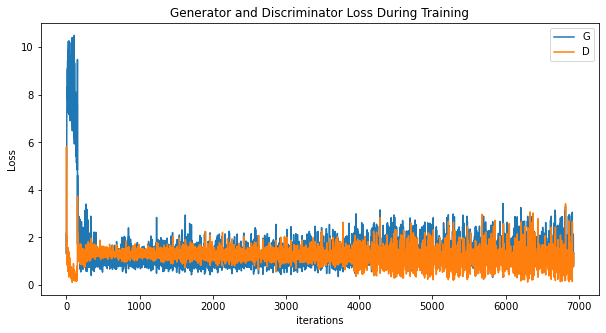

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

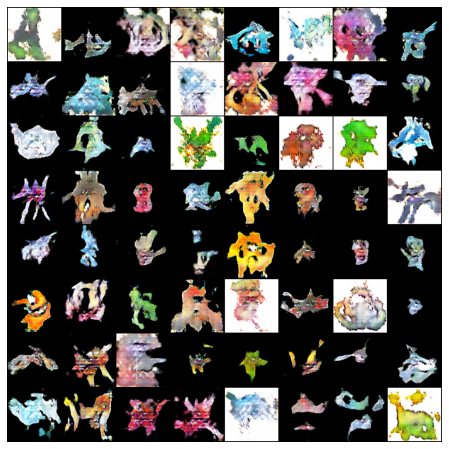

In [27]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


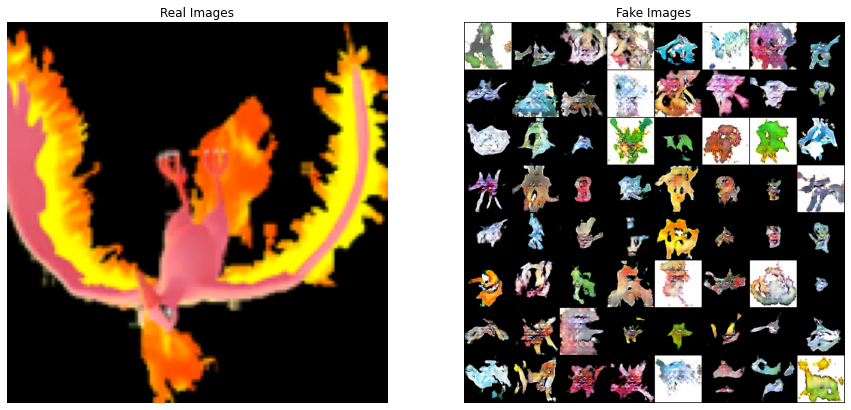

In [28]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


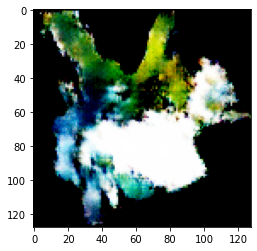

In [29]:
plt.imshow(np.transpose(G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


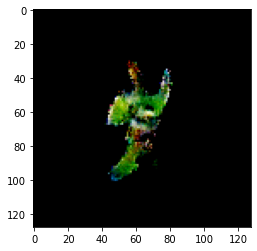

In [30]:
plt.imshow(np.transpose(G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


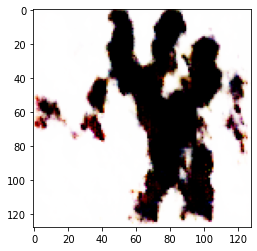

In [31]:
plt.imshow(np.transpose(G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


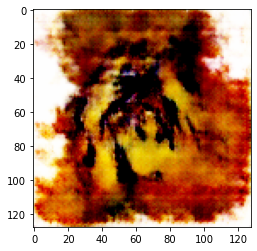

In [32]:
plt.imshow(np.transpose(G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

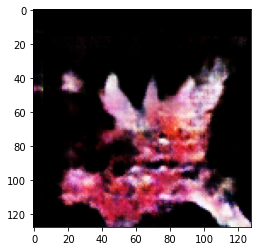

In [35]:
# img_list[-1][:,:64,:64].shape
i = 8
j = 4
plt.imshow(np.transpose(img_list[-1][:,128 * (i-1):128*i,128*(j-1):128*j],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape